In [20]:
!pip install torch
!pip install ray
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 40.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 91.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.0/322.0 KB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 106.2 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 126.7 MB/s eta 0:00:0000:01


In [1]:
import torch

if torch.cuda.is_available():
    print(f"GPU is available: {torch.cuda.get_device_name(0)}")
else:
    print("GPU is not available")

GPU is available: NVIDIA GeForce RTX 3060


In [2]:
import ray

ray.shutdown()
ray.init()

2024-09-29 03:35:36,237	WARNING utils.py:580 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2024-09-29 03:35:36,241	WARNING utils.py:592 -- Ray currently does not support initializing Ray with fractional cpus. Your num_cpus will be truncated from 15.36 to 15.
2024-09-29 03:35:37,429	INFO worker.py:1786 -- Started a local Ray instance.


Python version:,3.10.12
Ray version:,2.37.0


In [3]:
# Define a Ray remote function that uses the GPU
@ray.remote(num_gpus=1)
def gpu_matrix_multiply(size: int):
    # Ensure computations happen on the GPU
    device = torch.device('cuda')
    
    # Create random matrices
    matrix1 = torch.randn(size, size, device=device)
    matrix2 = torch.randn(size, size, device=device)
    
    # Perform matrix multiplication on the GPU
    result = torch.matmul(matrix1, matrix2)
    
    # Optionally, return some summary info
    return result.sum().item()

def matrix_multiply(size: int):
    matrix1 = torch.randn(size, size)
    matrix2 = torch.randn(size, size)
    result = torch.matmul(matrix1, matrix2)
    return result.sum().item()

In [4]:
import time
import matplotlib.pyplot as plt

cpu_times = []
gpu_times = []

for i in range(50):
    matrix_size = 1000 * i
    
    start_time2 = time.time()
    results = [matrix_multiply(matrix_size) for _ in range(4)]
    end_time2 = time.time()
    elapsed_time2 = end_time2 - start_time2
    cpu_times.append(elapsed_time2)
    print(f"Time taken for regular tasks: {elapsed_time2:.2f} seconds")
    
    start_time = time.time()
    futures = [gpu_matrix_multiply.remote(matrix_size) for _ in range(4)]
    results = ray.get(futures)
    end_time = time.time()
    elapsed_time = end_time - start_time
    gpu_times.append(elapsed_time)
    print(f"Time taken for GPU tasks: {elapsed_time:.2f} seconds")

Time taken for regular tasks: 0.00 seconds
Time taken for GPU tasks: 7.31 seconds
Time taken for regular tasks: 0.13 seconds
Time taken for GPU tasks: 7.53 seconds
Time taken for regular tasks: 0.50 seconds
Time taken for GPU tasks: 7.50 seconds
Time taken for regular tasks: 0.99 seconds
Time taken for GPU tasks: 7.27 seconds
Time taken for regular tasks: 1.93 seconds
Time taken for GPU tasks: 7.41 seconds
Time taken for regular tasks: 3.60 seconds
Time taken for GPU tasks: 7.55 seconds
Time taken for regular tasks: 5.57 seconds
Time taken for GPU tasks: 7.26 seconds
Time taken for regular tasks: 8.55 seconds
Time taken for GPU tasks: 8.11 seconds
Time taken for regular tasks: 12.08 seconds
Time taken for GPU tasks: 8.29 seconds
Time taken for regular tasks: 16.26 seconds
Time taken for GPU tasks: 8.29 seconds
Time taken for regular tasks: 15.93 seconds
Time taken for GPU tasks: 8.37 seconds
Time taken for regular tasks: 21.05 seconds
Time taken for GPU tasks: 8.53 seconds
Time taken f

RayTaskError(OutOfMemoryError): [36mray::gpu_matrix_multiply()[39m (pid=18130, ip=172.17.0.4)
  File "/tmp/ipykernel_7614/1063913856.py", line 12, in gpu_matrix_multiply
torch.OutOfMemoryError: CUDA out of memory. Tried to allocate 4.06 GiB. GPU 0 has a total capacity of 11.66 GiB of which 3.43 GiB is free. Process 446182 has 8.22 GiB memory in use. Of the allocated memory 8.11 GiB is allocated by PyTorch, and 3.59 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

2024-09-29 04:40:12,438	ERROR worker.py:409 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::gpu_matrix_multiply() (pid=18132, ip=172.17.0.4)
  File "/tmp/ipykernel_7614/1063913856.py", line 12, in gpu_matrix_multiply
torch.OutOfMemoryError: CUDA out of memory. Tried to allocate 4.06 GiB. GPU 0 has a total capacity of 11.66 GiB of which 3.43 GiB is free. Process 446184 has 8.22 GiB memory in use. Of the allocated memory 8.11 GiB is allocated by PyTorch, and 3.59 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
2024-09-29 04:40:14,438	ERROR worker.py:409 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::gpu_matrix_multiply() (pid=18131, ip=172.17.0.4)
  File "/tmp/ipykernel_7614/1063913856.py", line 12, in 

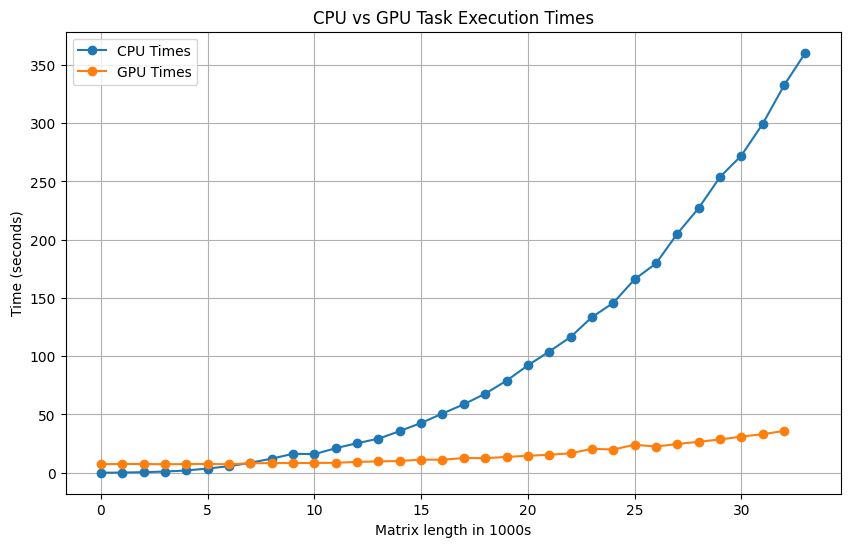

In [7]:
# Create the plot
plt.figure(figsize=(10, 6))

# Plot CPU times
plt.plot(cpu_times, label='CPU Times', marker='o')

# Plot GPU times
plt.plot(gpu_times, label='GPU Times', marker='o')

# Set labels and title
plt.xlabel('Matrix length in 1000s')
plt.ylabel('Time (seconds)')
plt.title('CPU vs GPU Task Execution Times')

# Add legend
plt.legend()

# Add grid
plt.grid(True)

# Display the plot
plt.show()